# Data description & Problem statement: 
I will use the Yelp Review Data Set from Kaggle. Each observation in this dataset is a review of a particular business by a particular user. The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review. The "cool" column is the number of "cool" votes this review received from other Yelp users. The "useful" and "funny" columns are similar to the "cool" column. The goal of this project is to predict whether the customer will rate the business as GOOD or BAD.


# Workflow:
- Load the training and test datasets
- Data cleaning (e.g. remove formats and punctuations)
- Basic data exploration
- Text vectorization, using "Bag of Words" technique
- Use "tf-idf transformation", and find the "N-grams" to improve the model performace
- Use a supervised classifier (e.g. Logistic Regression, Naive Bayes, etc.) for text classification: Use Grid-Serach along with Cross-Validation technique for finding the optimal hyper-parameters of best classifier
- Evaluate the performance of best classifier on the test data set, by calculating:
     - f1, Precision, Recall scores
     - Confusion matrix
     - ROC curve
- Finally, determine most important words/features during semantic analysis for both Ham and Spam emails

   * Note: I repeat abovementioned process with and without Word Normalization (i.e. using lammatization/stemming) for the sake of comparison. For the word normalization I use "SpaCy" library.

In [1]:
import sklearn
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# we insatll and import spacy package for some advanced tokenizaion techniques:
import spacy

# we also install and import mglearn package (using !pip install mglearn) for some interesting visualization of results:
import mglearn

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 3EA9-93A4

 Directory of C:\Users\rhash\Documents\Datasets\NLP projects (sklearn & Spark)

09/11/2018  01:41 PM    <DIR>          .
09/11/2018  01:41 PM    <DIR>          ..
09/11/2018  11:21 AM    <DIR>          .ipynb_checkpoints
09/10/2018  11:29 AM    <DIR>          aclImdb
09/10/2018  11:57 AM    <DIR>          cache
08/02/2018  06:00 PM           100,912 Dataset_Challenge_Dataset_Agreement.pdf
09/11/2018  12:54 AM           149,226 IMDb review (positive vs negative reviews, in sklearn).ipynb
09/11/2018  10:02 AM             8,797 IMDb review (topic modeling, sklearn).ipynb
04/18/2011  02:53 PM             5,868 readme
09/11/2018  10:53 AM           198,102 sms filteration (ham vs spam, sklearn).ipynb
09/11/2018  10:54 AM            27,708 sms filteration (topic modeling, sklearn)-Copy1.ipynb
03/15/2011  10:36 PM           477,907 SMSSpamCollection
09/11/2018  01:41 PM            97,890 Yelp review (1 vs 5 star, sklearn).ipynb
02/0

# load, prepare and explore the text data: 

In [5]:
reviews = pd.read_csv('yelp_review.csv')

In [6]:
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,5261668.0,3.727739,1.433593,1.0,3.0,4.0,5.0,5.0
useful,5261668.0,1.385085,4.528727,-1.0,0.0,0.0,2.0,3364.0
funny,5261668.0,0.509196,2.686168,0.0,0.0,0.0,0.0,1481.0
cool,5261668.0,0.586092,2.233706,-1.0,0.0,0.0,1.0,1105.0


In [7]:
reviews.head(3)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0


In [8]:
starsCount=pd.DataFrame(reviews['stars'].value_counts()).reset_index()
starsCount.columns=['stars', 'count']
starsCount.sort_values('stars')

,stars,count
2,1,731363
4,2,438161
3,3,615481
1,4,1223316
0,5,2253347


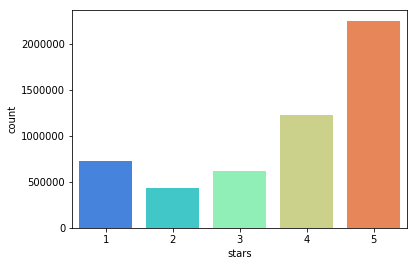

In [9]:
sns.countplot(x='stars', data=reviews, palette='rainbow')
plt.show()

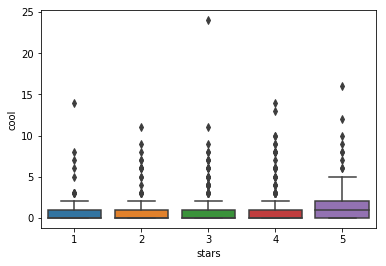

In [10]:
sns.boxplot(x=reviews['stars'][0:1000], y=reviews['cool'][0:1000])
plt.show()

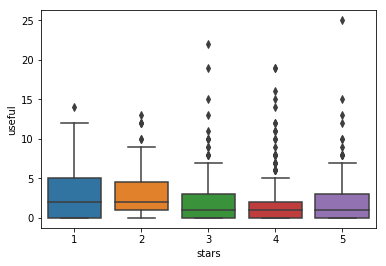

In [11]:
sns.boxplot(x=reviews['stars'][0:1000], y=reviews['useful'][0:1000])
plt.show()

In [12]:
reviews['length']= reviews['text'].apply(len)   #.map(lambda x: len(x))

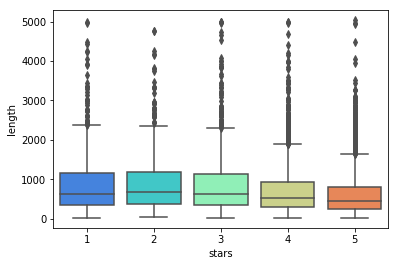

In [13]:
sns.boxplot(x=reviews['stars'][1:10000], y=reviews['length'][1:10000], palette='rainbow')
plt.show()

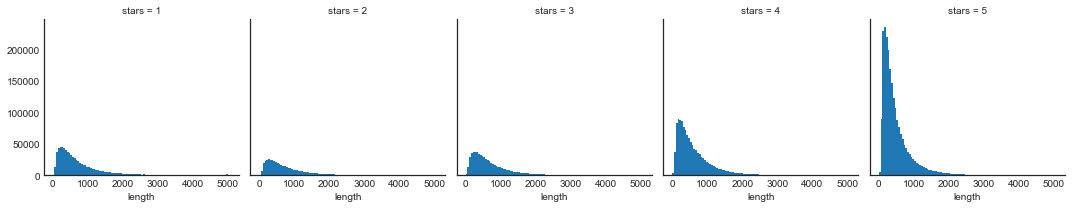

In [14]:
sns.set_style('white')
g=sns.FacetGrid(reviews, col='stars')
g.map(plt.hist, 'length', bins=100)
plt.show()

In [15]:
reviews.groupby('stars').mean()

,useful,funny,cool,length
stars,,,,
1,2.210875,0.707292,0.279544,764.181383
2,1.625610,0.668248,0.415523,769.211320
3,1.341018,0.614906,0.646093,716.108068
4,1.349785,0.567573,0.824651,631.355725
5,1.101492,0.353408,0.572854,492.783366


In [16]:
featureCorr=reviews.groupby('stars').mean().corr()
featureCorr

,useful,funny,cool,length
useful,1.000000,0.797196,-0.767887,0.750374
funny,0.797196,1.000000,-0.442860,0.981430
cool,-0.767887,-0.442860,1.000000,-0.503737
length,0.750374,0.981430,-0.503737,1.000000


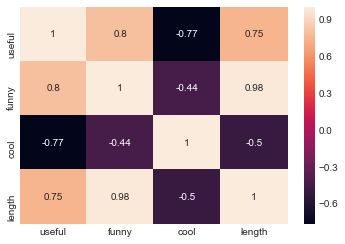

In [17]:
sns.heatmap(featureCorr, annot=True)
plt.show()

In [18]:
reviews['stars']=reviews['stars'].map({1:0, 2:0, 3:0, 4:1, 5:1})

In [19]:
from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test = train_test_split(reviews['text'][0:100000], reviews['stars'][0:100000], 
                                                          test_size=0.3, shuffle=True, random_state=42)

In [20]:
reviews['stars'].value_counts()

1    3476663
0    1785005
Name: stars, dtype: int64

# Semantic analysis with tf-idf and n-grams techniques using LR model: 
    * Approach 1: without word normalization (i.e. lammatization or stemming)

In [21]:
# We find the best setting of n-gram range and logistic regression parameter using a grid search:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold


pipe = make_pipeline(TfidfVectorizer(min_df=10, max_df=0.5), 
                     LogisticRegression(random_state=42, class_weight='balanced')) 

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams 
param_grid = {"logisticregression__C": [ 0.1, 1, 5, 10, 100],              
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

kfold=StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid1 = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc') 
grid1.fit(text_train, y_train) 

G=pd.DataFrame(grid1.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
8,51.100049,0.227684,18.198105,0.008478,5,"(1, 3)","{'logisticregression__C': 5, 'tfidfvectorizer_...",0.957627,0.959521,0.958574,0.000947,1,0.998518,0.998395,0.998456,6.146672e-05
7,22.780939,0.203077,12.464150,0.061455,5,"(1, 2)","{'logisticregression__C': 5, 'tfidfvectorizer_...",0.957081,0.958868,0.957974,0.000893,2,0.997630,0.997479,0.997555,7.537140e-05
11,50.006844,0.024434,18.694941,0.072805,10,"(1, 3)","{'logisticregression__C': 10, 'tfidfvectorizer...",0.956956,0.958778,0.957867,0.000911,3,0.999843,0.999842,0.999842,4.799789e-07


In [22]:
print("Best parameters:\n{}".format(grid1.best_params_), '\n')
print("Best cross-validation score: {:.2f}".format(grid1.best_score_)) 
print("Test score: {:.2f}".format(grid1.score(text_test, y_test)))

Best parameters:
{'logisticregression__C': 5, 'tfidfvectorizer__ngram_range': (1, 3)} 

Best cross-validation score: 0.96
Test score: 0.96


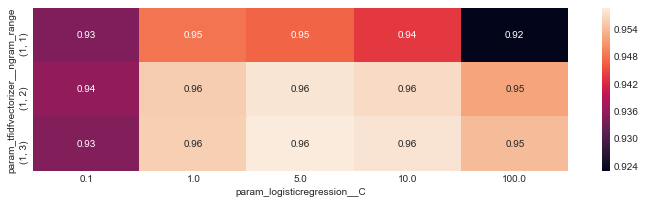

In [23]:
# extract scores from grid_search and visualize them for ranges of parametrs:
plt.figure().set_size_inches(12, 3)
h=G[["param_logisticregression__C", "param_tfidfvectorizer__ngram_range", "mean_test_score"]] .pivot_table(index="param_tfidfvectorizer__ngram_range", columns="param_logisticregression__C", values="mean_test_score")
sns.heatmap(h, annot=True)
plt.show()

In [37]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test, grid1.predict(text_test), target_names=['1-3 stars', '4-5 stars'])
print(report)

             precision    recall  f1-score   support

  1-3 stars       0.85      0.87      0.86     10108
  4-5 stars       0.94      0.92      0.93     19892

avg / total       0.91      0.90      0.90     30000



Confusion matrix, without normalization
[[ 8844  1264]
 [ 1604 18288]]
Normalized confusion matrix
[[0.87 0.13]
 [0.08 0.92]]


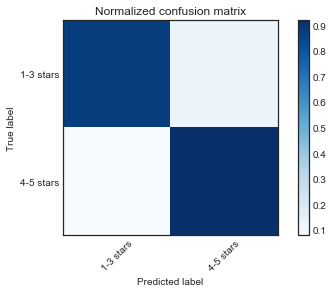

In [25]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["1-3 stars", "4-5 stars"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid1.predict(text_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

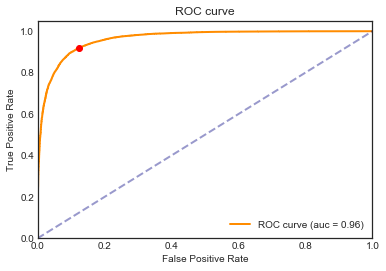

In [26]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid1.predict_proba(text_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid1.predict_proba(text_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling:


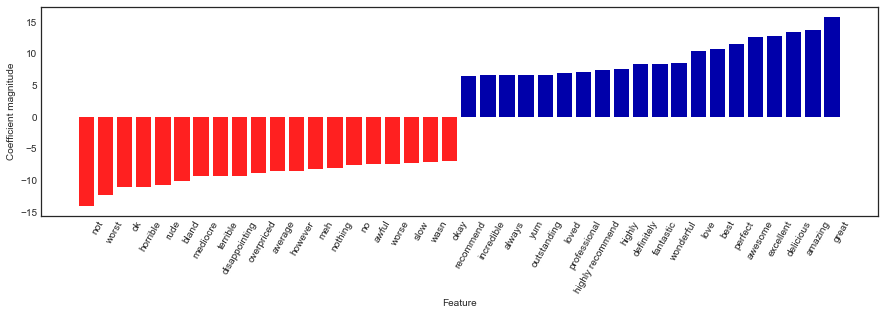

In [27]:
# Most important features when using unigrams, bigrams:
vect = grid1.best_estimator_.named_steps['tfidfvectorizer'] 
feature_names = np.array(vect.get_feature_names()) 
coef = grid1.best_estimator_.named_steps['logisticregression'].coef_ 
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=20)
print('Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling:')

# Semantic analysis with tf-idf and n-grams techniques using LR model: 
    * Approach 2: with word normalization (i.e. using lammatization or stemming)

In [28]:
# run following script in the command line with admin privilage, to load the english package in spaCy:
# python -m spacy download en

In [29]:
# Technicality: we want to use the regexp-based tokenizer that is used by CountVectorizer 
# and only use the lemmatization from spacy. 
# We replace en_nlp.tokenizer (the spacy tokenizer) with the regexp-based tokenization:

from sklearn.feature_extraction.text import CountVectorizer
import re 

# regexp used in CountVectorizer 
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer 
en_nlp = spacy.load('en') 
old_tokenizer = en_nlp.tokenizer 

# replace the tokenizer with the preceding regexp 
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline (now using our own tokenizer) 
def custom_tokenizer(document):    
    doc_spacy = en_nlp(document)    
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer 
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer,
                             min_df=10, 
                             max_df=0.6,
                             ngram_range=(1, 2)).fit(text_train)

In [30]:
# transform text_train using CountVectorizer with lemmatization 
X_train_lemma = lemma_vect.transform(text_train) 
X_test_lemma = lemma_vect.transform(text_test[0:1000])

print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

X_train_lemma.shape: (70000, 82285)


In [31]:
# We find the best logistic regression parameter using a grid search:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfTransformer(), 
                     LogisticRegression(random_state=42, class_weight='balanced')) 

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams 
param_grid = {"logisticregression__C": [0.1, 1, 10, 100]}

kfold=StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid2 = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc')  
grid2.fit(X_train_lemma, y_train) 

G=pd.DataFrame(grid2.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,9.416883,0.071173,0.394620,0.028705,10,{'logisticregression__C': 10},0.957312,0.958185,0.958416,0.957971,0.000475,1,0.999534,0.999526,0.999572,0.999544,1.994347e-05
1,6.067157,0.252283,0.439823,0.047712,1,{'logisticregression__C': 1},0.955931,0.956600,0.957260,0.956597,0.000543,2,0.981665,0.981461,0.981454,0.981527,9.761277e-05
3,9.961977,1.462686,0.213963,0.038698,100,{'logisticregression__C': 100},0.952851,0.953800,0.953783,0.953478,0.000444,3,1.000000,1.000000,1.000000,1.000000,9.956242e-09


In [32]:
print("Best parameters:\n{}".format(grid2.best_params_), '\n')
print("Best cross-validation score: {:.2f}".format(grid2.best_score_)) 
print("Test score: {:.2f}".format(grid2.score(X_test_lemma, y_test[0:1000])))

Best parameters:
{'logisticregression__C': 10} 

Best cross-validation score: 0.96
Test score: 0.95


In [33]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test[0:1000], grid2.predict(X_test_lemma), target_names=['spam', 'ham'])
print(report)

             precision    recall  f1-score   support

       spam       0.82      0.83      0.83       347
        ham       0.91      0.90      0.91       653

avg / total       0.88      0.88      0.88      1000



Confusion matrix, without normalization
[[289  58]
 [ 63 590]]
Normalized confusion matrix
[[0.83 0.17]
 [0.1  0.9 ]]


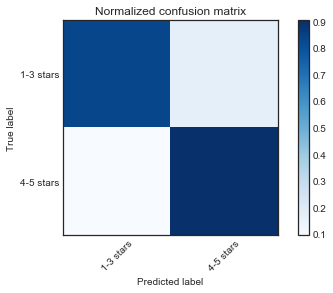

In [34]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["1-3 stars", "4-5 stars"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test[0:1000], grid2.predict(X_test_lemma))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

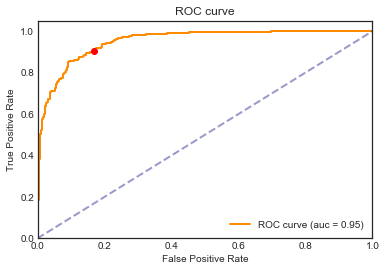

In [35]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[0:1000]),grid2.predict_proba(X_test_lemma)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test[0:1000]), grid2.predict_proba(X_test_lemma)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling:


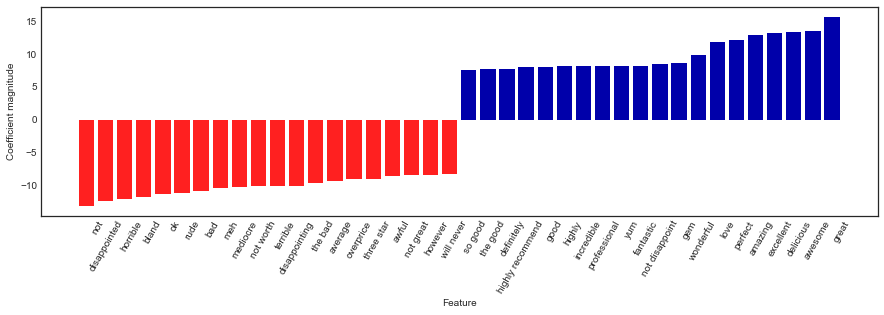

In [36]:
# Most important features when using unigrams, bigrams: 
feature_names = np.array(lemma_vect.get_feature_names()) 
coef = grid2.best_estimator_.named_steps['logisticregression'].coef_ 
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=20)
print('Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling:')